## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.pyplot as plt

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

### Defining activation function

In [2]:
def relu(z):
    """Apply rectified linear unit activation to input array."""
    z = (z > 0) * z
    return z

#### Relu:
$$ f(x) = max(0, x)$$

$$ f'(x) = max(0, sign(x))$$

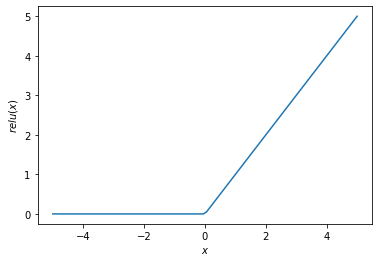

## Creating a synthetic dataset

In [3]:
X = np.random.randn(900,2)
beta = np.random.randn(2,1)
y = np.log(X@beta+20) - X[:,1:2]**2 #+ np.random.randn(900,1)

## Visualizing Dataset

Dataset is strictly not viable to fit a linear plane.

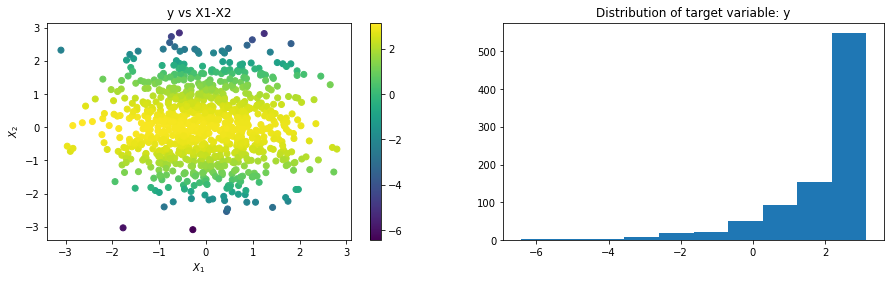

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].scatter(*X.T, c=y.ravel())
ax[0].set_xlabel('$X_1$')
ax[0].set_ylabel('$X_2$')
fig.colorbar(ScalarMappable(norm=Normalize(y.min(), y.max())), ax=ax[0])
ax[0].set_title('y vs X1-X2')
ax[1].set_title('Distribution of target variable: y')
_ = ax[1].hist(y.ravel())


# Defining helper functions

### Batches

A generator object to yield rows of desired batch size from X and y.

In [5]:
def batches(X, batch_size=32):
    """Generate batches from given np.ndarray.
    
    Array must be at least 2-D.
    """
    if batch_size >= X.shape[0]:
        yield X
    else:
        num_iters = (X.shape[0] // batch_size)
        if not (X.shape[0] % batch_size == 0):
            num_iters += 1
        for i in range(num_iters):
            result = X[i * batch_size : (i + 1) * batch_size]
            yield result

## Forward Propagation

Propagate input through network using current parameters. All intermediate layers and $\hat{y}$ is calculated, activations are returned to be used in back-propagation.

In [6]:
def forward_propagate(X, y, W1, b1, W2, b2, W3, b3):
    """Perform one step of forward propagation."""
    A0 = X
    y0 = y
    m = A0.shape[0]

    Z1 = A0 @ W1 + b1
    A1 = relu(Z1)
    Z2 = A1 @ W2 + b2
    A2 = relu(Z2)
    y_pred = A2 @ W3 + b3
    loss = ((y - y_pred)**2).mean()
    
    return loss, y_pred, A1, A2

## Back-propagation

Gradients are propagated back from loss calculated at output using chain rule. Calculated gradients multiplied by a learning rate are used to update parameters to minimize loss.

$$w_i := w_i - \alpha \frac{\partial L}{\partial w_i}$$
$$b_i := b_i - \alpha \frac{\partial L}{\partial b_i}$$

In [7]:
def back_propagate(X, y, y_pred, W1, b1, W2, b2, W3, b3, A1, A2, lr):
    """Perform one step of back-propagation.
    
    Calculates gradients and updates parameters.
    """
    A0 = X
    y0 = y
    m = A0.shape[0]
    
    dy_pred = y_pred - y0
    dA2 = dy_pred @ W3.T
    dZ2 = dA2 * (A2 > 0).astype(float)
    dA1 = dZ2 @ W2.T
    dZ1 = dA1 * (A1 > 0).astype(float)
    
    dW3 = 1 / m * (A2.T @ dy_pred)
    db3 = 1 / m * dy_pred.sum(axis=0, keepdims=True)
    dW2 = 1 / m *(A1.T @ dZ2)
    db2 = 1 / m * dZ2.sum(axis=0, keepdims=True)
    dW1 = 1 / m * (A0.T @ dZ1)
    db1 = 1 / m * dZ1.sum(axis=0, keepdims=True)
    
    W1 = W1 - lr * dW1
    b1 = b1 - lr * db1
    W2 = W2 - lr * dW2
    b2 = b2 - lr * db2
    W3 = W3 - lr * dW3
    b3 = b3 - lr * db3
    
    return W1, b1, W2, b2, W3, b3

## Train neural network

Perform forward and backward propagation for specified number of epochs.

In [8]:
def train_network(X, y, W1, b1, W2, b2, W3, b3, batch_size=32, epochs=1000, lr=0.01, verbose=1):
    """Train neural network and return learned parameters and final loss.
    
    Returns:
    -----------
    params : Tuple[W1, b1, W2, b2, W3, b3]
    loss   : float, computed loss for learnt parameters. 
    """
    loss_history = []
    params = W1, b1, W2, b2, W3, b3
    for epoch in range(epochs):
        for rx, ry in zip(batches(X, batch_size=batch_size), batches(y, batch_size=batch_size)):
            loss, y_pred, A1, A2 = forward_propagate(rx, ry, *params)
            params = back_propagate(rx, ry, y_pred, *params, A1, A2, lr)
            loss_history.append(loss)

        if epoch % 100==0 and verbose:
            loss, y_pred, *_ = forward_propagate(X, y, *params)
            print("Loss:", loss)
    loss, *_ = forward_propagate(X, y, *params)
    return params, loss, loss_history

## Batch Gradient Descent

Slow but certain steps toward minimum loss.

In [9]:
W1 = np.random.randn(2,56)
b1 = np.zeros(shape=(1,56))
W2 = np.random.randn(56,24)
b2 = np.zeros(shape=(1,24))
W3 = np.random.randn(24,1)
b3 = np.zeros(shape=(1,1))

params = W1, b1, W2, b2, W3, b3

In [10]:
%%time
params, loss, loss_history = train_network(X, y, *params, batch_size=900, epochs=101, lr=0.01)

Loss: 1845.707267440051
Loss: 0.6752586047023894
Wall time: 404 ms


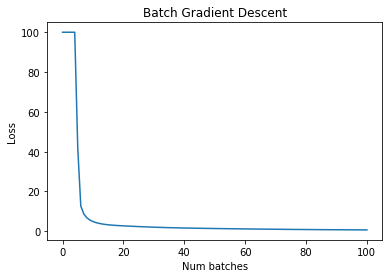

In [11]:
plt.plot(np.clip(loss_history, 0, 100))
plt.title('Batch Gradient Descent')
plt.xlabel('Num batches')
_ = plt.ylabel('Loss')

## Mini-batch Gradient Descent

In [12]:
W1 = np.random.randn(2,56)
b1 = np.zeros(shape=(1,56))
W2 = np.random.randn(56,24)
b2 = np.zeros(shape=(1,24))
W3 = np.random.randn(24,1)
b3 = np.zeros(shape=(1,1))

params = W1, b1, W2, b2, W3, b3

In [13]:
%%time
params, loss, loss_history = train_network(X, y, *params, 32, 101, 0.001)

Loss: 3.674717496819496
Loss: 0.08908058643589387
Wall time: 742 ms


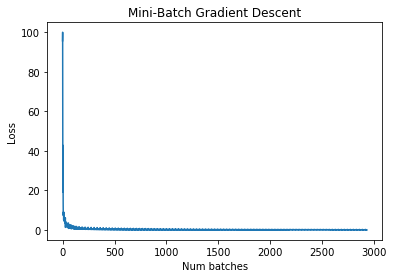

In [14]:
plt.plot(np.clip(loss_history, 0, 100))
plt.title('Mini-Batch Gradient Descent')
plt.xlabel('Num batches')
_ = plt.ylabel('Loss')

## Stochastic Gradient Descent

In [15]:
W1 = np.random.randn(2,56)
b1 = np.zeros(shape=(1,56))
W2 = np.random.randn(56,24)
b2 = np.zeros(shape=(1,24))
W3 = np.random.randn(24,1)
b3 = np.zeros(shape=(1,1))

params = W1, b1, W2, b2, W3, b3

In [16]:
%%time
params, loss, loss_history = train_network(X, y, *params, 1, 101, lr=0.001)

Loss: 0.3981677942575804
Loss: 0.011603828920318424
Wall time: 18.4 s


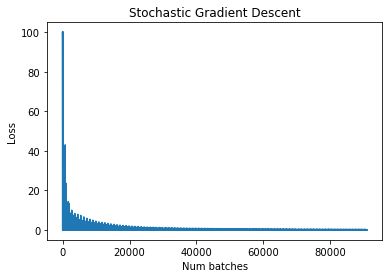

In [17]:
plt.plot(np.clip(loss_history, 0, 100))
plt.title('Stochastic Gradient Descent')
plt.xlabel('Num batches')
_ = plt.ylabel('Loss')

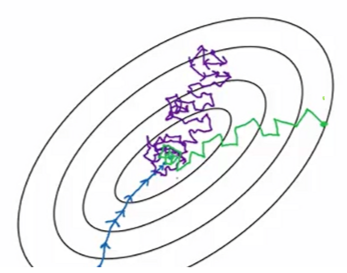